In [1]:
import extract_features
from scipy import product
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, n_classes,display_labels):
    
    fig, ax = plt.subplots(figsize=(10,10))
    cm = cm
    
    im_ = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    
    text_ = np.empty_like(cm, dtype=object)
    values_format = '.2g'

    # print text with appropriate color depending on background
    thresh = (cm.max() - cm.min()) / 2.
    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text_[i, j] = ax.text(j, i,format(cm[i, j], values_format),
                                   ha="center", va="center",
                                   color=color)
        
    fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation='vertical')

    figure_ = fig
    ax_ = ax

In [3]:
def grid_search(X_train, y_train, models, score, cv, refit):
    
    bestmodels = dict()
    for name, value in models.items():
        
        print('*********** Model: {} ***********'.format(name))

        estimator = value['model']
        tuned_parameters = value['parameters']
        
        clf = GridSearchCV(estimator, tuned_parameters, scoring=score, cv=cv, n_jobs=-1,refit=refit, verbose=2)

        t_beg = time.time()
        clf.fit(X_train_scaled, y_train)
        selection_time = time.time() - t_beg

        print('El tiempo de selección fue: {:0.3f}'.format(selection_time))
        print("Los mejores parámetros son:")
        print(clf.best_params_)

        bestmodels[name] = dict()
        bestmodels[name]['bestModel'] = clf.best_estimator_
        bestmodels[name]['bestParams'] = clf.best_params_
        bestmodels[name]['bestScore'] = clf.best_score_
        bestmodels[name]['selectionTime'] = selection_time

        for metric in score:
            mean_name = 'mean_test_{}'.format(metric)
            std_name = 'std_test_{}'.format(metric)

            idx_mean_metric = np.argmax(clf.cv_results_[mean_name])
            idx_std_metric = np.argmax(clf.cv_results_[std_name])

            mean = clf.cv_results_[mean_name][idx_mean_metric]
            std = clf.cv_results_[std_name][idx_std_metric]

            bestmodels[name]['mean_{}'.format(metric)] = mean
            bestmodels[name]['std_{}'.format(metric)] = std

    return bestmodels

In [4]:
full_data = extract_features.matriz_features('features')
X = full_data[:,:-1]
y = full_data[:,-1]

In [5]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
models = {
    'SVM': {
        'model':SVC(),
        'parameters':[
            {'C': [0.01,0.1,1,10], 'kernel': ['linear'], 'decision_function_shape':['ovr']},
            {'C': [0.01,0.1,1,10], 'gamma': ['scale','auto',0.01,0.1], 'kernel': ['rbf'], 'decision_function_shape':['ovr']}
        ]
    },
    'MLP': {
        'model': MLPClassifier(),
        'parameters': [
            {'hidden_layer_sizes': [(5),(5,10,5),(5,10,20,10,5),(10),(10,20,10),(20)],
             'activation': ['tanh','relu','logistic'], 'solver': ['adam'], 'learning_rate': ['constant'],
             'learning_rate_init': [0.001,0.01]
            }
        ]
    },
    'LINEAR': {
        'model': LogisticRegression(n_jobs=-1),
        'parameters': [
            {'penalty': ['elasticnet'], 'solver': ['saga'], 'multi_class': ['multinomial', 'ovr'], 'C': [0.01, 0.1, 1],
             'l1_ratio': [0, 0.25], 'max_iter': [100, 150]},
            {'penalty': ['l1', 'l2'], 'solver': ['saga'], 'multi_class': ['multinomial', 'ovr'], 'C': [0.01, 0.1, 1],
             'max_iter': [100, 150]},
            {'penalty': ['none'], 'solver': ['saga', 'lbfgs'], 'multi_class': ['multinomial', 'ovr'],
             'max_iter': [100, 150]}
        ]
    },
    'RANDOM FOREST':{
        'model': RandomForestClassifier(n_jobs=-1),
        'parameters':[
            {'n_estimators': [5,15,45], 'criterion': ['gini','entropy'],'max_features':['sqrt','log2'],
             'bootstrap': [True],'max_samples':[0.25,0.5,0.75]},
            {'n_estimators': [5,15,45], 'criterion': ['gini','entropy'], 'max_features':['sqrt','log2'],
             'bootstrap': [False]}
        ]
    }
}

scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1': 'f1_macro'}

refit = 'Recall'

bestmodels = grid_search(X_train_scaled,y_train,models,cv=7,score=scoring,refit=refit)

*********** Model: SVM ***********
El tiempo de selección fue: 7738.368
Los mejores parámetros son:
{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf'}
*********** Model: MLP ***********
El tiempo de selección fue: 983.347
Los mejores parámetros son:
{'activation': 'relu', 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'adam'}
*********** Model: LINEAR ***********
El tiempo de selección fue: 519.989
Los mejores parámetros son:
{'max_iter': 150, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs'}
*********** Model: RANDOM FOREST ***********
El tiempo de selección fue: 349.465
Los mejores parámetros son:
{'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'max_samples': 0.75, 'n_estimators': 45}


***************SVM***************
              precision    recall  f1-score   support

           0       0.46      0.35      0.40      3966
           1       0.44      0.51      0.48      4001
           2       0.46      0.49      0.47      4033

    accuracy                           0.45     12000
   macro avg       0.45      0.45      0.45     12000
weighted avg       0.45      0.45      0.45     12000

***************MLP***************
              precision    recall  f1-score   support

           0       0.45      0.37      0.41      3966
           1       0.45      0.49      0.47      4001
           2       0.45      0.49      0.47      4033

    accuracy                           0.45     12000
   macro avg       0.45      0.45      0.45     12000
weighted avg       0.45      0.45      0.45     12000

***************LINEAR***************
              precision    recall  f1-score   support

           0       0.43      0.29      0.35      3966
           1       0.43 

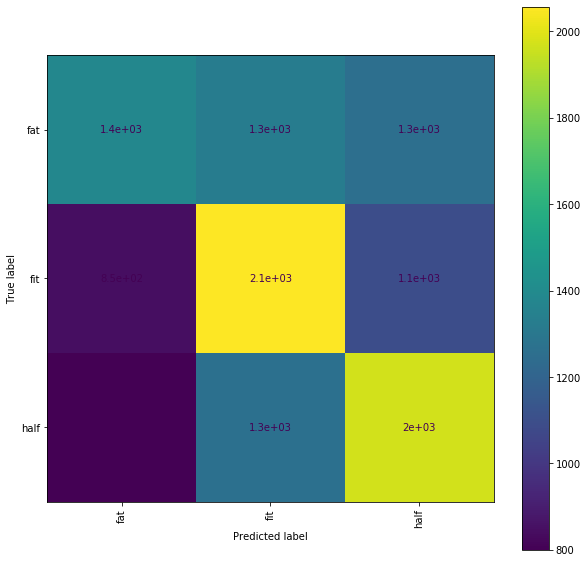

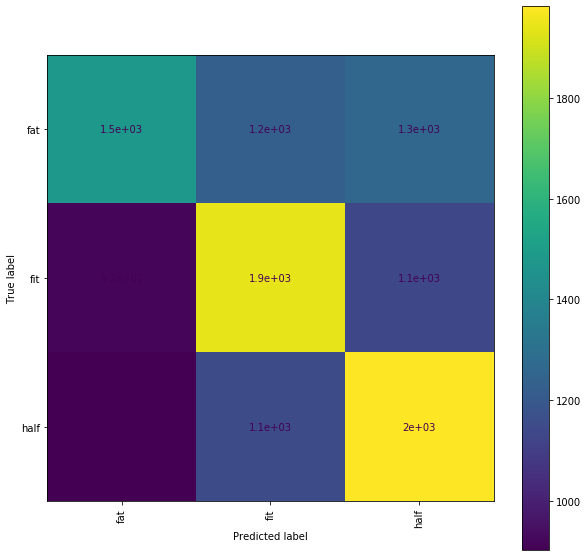

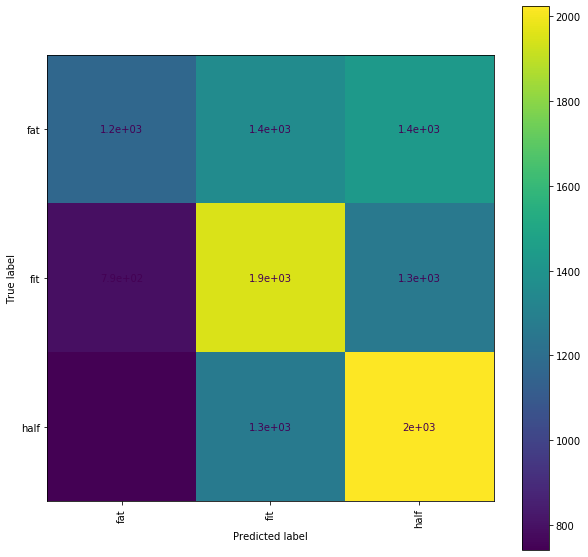

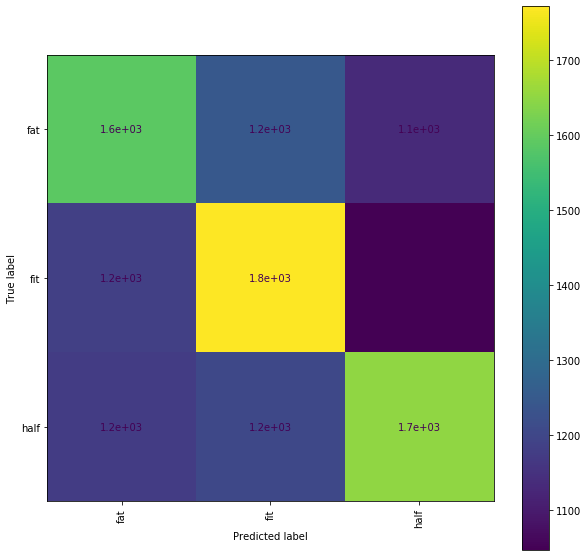

In [8]:
num_classes = 3
for name, value in bestmodels.items():
    print('***************{}***************'.format(name))
    y_true, y_pred = y_test, value['bestModel'].predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    ####AQUI EL PLOT####
    cm = confusion_matrix(y_true, y_pred, labels=['0','1','2'])
    plot_confusion_matrix(cm, 3,['fat','fit','half'])
    ####HASTA AQUI EL PLOT####